In [15]:
import io
import os
import requests

import pandas as pd
import numpy as np

from fink_utils.sso.spins import estimate_sso_params
from fink_utils.sso.spins import func_hg1g2_with_spin
# from fink_spins.plots import plot_lightcurve, plot_phase

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [25]:
def plot_ast(ssnamenr: str):
    """ Plot the lightcurve of an asteroid
    """
    
    # get data for object 8467
    r = requests.post(
        'https://fink-portal.org/api/v1/sso',
        json={
            'n_or_d': ssnamenr,
            'withEphem': True,
            'output-format': 'json'
        }
    )
    
    # Format output in a DataFrame
    pdf = pd.read_json(io.BytesIO(r.content))
    
    params = ['H', 'G1', 'G2', 'R', 'alpha0', 'delta0']
    bounds = (
        [0, 0, 0, 1e-1, 0, -np.pi/2],
        [30, 1, 1, 1, 2*np.pi, np.pi/2]
    )
    p0 = [15.0, 0.15, 0.15, 0.8, np.pi, 0.0]
    x = [
        np.deg2rad(pdf['Phase'].values),
        np.deg2rad(pdf['i:ra'].values),
        np.deg2rad(pdf['i:dec'].values)
    ]

    # Multi-band fit
    outdic = estimate_sso_params(
        magpsf_red=pdf['i:magpsf_red'].values,
        sigmapsf=pdf['i:sigmapsf'].values,
        phase=np.deg2rad(pdf['Phase'].values),
        filters=pdf['i:fid'].values,
        ra=np.deg2rad(pdf['i:ra'].values),
        dec=np.deg2rad(pdf['i:dec'].values),
        p0=p0,
        bounds=bounds,
        model='SHG1G2',
        normalise_to_V=False
    )
    
    fig, ax = plt.subplots(
        2, 1, 
        figsize=(15, 6), 
        sharex=True, 
        gridspec_kw={
           'top':0.995, 
           'left':0.075,
           'right':0.995,
           'bottom':0.085,
           'hspace':0.02, 
           'height_ratios': [2,1]
       }
    )
    
    colordic = {1: 'C0', 2: 'C1'}
    
    for filt in np.unique(pdf['i:fid']):
        maskFilt = pdf['i:fid'] == filt

        popt = []
        for pindex, param in enumerate(params):
            if pindex >= 3:
                suffix = ''
            else:
                suffix = '_{}'.format(filt)

            if pindex <= 3:
                popt.append(outdic[param + suffix])
            else:
                popt.append(np.deg2rad(outdic[param + suffix]))

        print(popt)
    
        ax[0].errorbar(
            pdf.loc[maskFilt, 'Phase'],
            pdf.loc[maskFilt, 'i:magpsf_red'],
            pdf.loc[maskFilt, 'i:sigmapsf'],
            ls = '', marker='o', color=colordic[filt]
        )

        ax[0].plot(
            pdf.loc[maskFilt, 'Phase'],
            func_hg1g2_with_spin(np.array(x)[:, maskFilt], *popt),
            ls = '', marker='^', color=colordic[filt], alpha=0.5
        )

        residuals = pdf.loc[maskFilt, 'i:magpsf_red'] - func_hg1g2_with_spin(np.array(x)[:, maskFilt], *popt)
        ax[1].errorbar(
            pdf.loc[maskFilt, 'Phase'],
            residuals,
            pdf.loc[maskFilt, 'i:sigmapsf'],
            color=colordic[filt], ls = '', marker='o'
        )

        # rms = np.sqrt(np.mean(residuals**2))

    ax[1].axhline(0, ls='--', color='black', lw=2)
    
    ax[0].invert_yaxis()
    ax[1].set_xlabel('Phase')
    ax[0].set_ylabel('Magnitude')
    ax[1].set_ylabel('Difference')
    plt.show()

In [4]:
# # get the ssoft
# r = requests.post(
#   'https://fink-portal.org/api/v1/ssoft',
#   json={
#     'output-format': 'parquet'
#   }
# )

# # Format output in a DataFrame
# data = pd.read_parquet(io.BytesIO(r.content))

In [5]:
# Local Configuration
data_fink = '../'
bft_file = os.path.join(data_fink,'data','ssoBFT-latest.parquet')

In [6]:
cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ] 

bft = pd.read_parquet(bft_file, columns=cols)

data = data.merge( bft, left_on='sso_name', right_on='sso_name', how='left' )

In [7]:
# ZTF filters
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])


mag_to_V ={
        1: -0.2833,  # ZTF g
        2: 0.1777,   # ZTF r
        3: 0.4388,   # ATLAS orange
        4: -0.0986   # ATLAS cyan
    }

fink_colors = ['#15284F', '#F5622E']

## Quality cuts

In [8]:
thres = 1e-3

# SHG1G2 ZTF
mask_sHG1G2_g = (data.G1_1>thres)  & (data.G2_1>thres) & ((1-data.G1_1-data.G2_1)>thres)
mask_sHG1G2_r = (data.G1_2>thres)  & (data.G2_2>thres) & ((1-data.G1_2-data.G2_2)>thres)
mask_sHG1G2_ZTF = mask_sHG1G2_g & mask_sHG1G2_r
mask_sHG1G2_fit = (data.fit==0)  & ((data.status==2) | (data.status==4))
mask_sHG1G2 = mask_sHG1G2_fit & mask_sHG1G2_ZTF 

In [9]:
np.sum(mask_sHG1G2)

48217

## Good sample

In [11]:
# mask = ~pd.isnull(pdf['rms'])
good = data[mask_sHG1G2].sort_values('rms', ascending=True)

In [45]:
good.head(5)[['ssnamenr', 'fit', 'status', 'rms_1', 'rms_2', 'rms', 'chi2red', 'G1_1', 'G2_1', 'H_1', 'err_H_1']]

,ssnamenr,fit,status,rms_1,rms_2,rms,chi2red,G1_1,G2_1,H_1,err_H_1
93071,540206,0.0,2.0,0.023078,0.032913,0.028519,0.170845,0.727350,0.158675,16.926334,4.316790
34671,154,0.0,2.0,0.028154,0.032809,0.029762,2.250893,0.107125,0.186341,7.317997,0.504531
2277,366,0.0,2.0,0.032051,0.032471,0.032268,2.368921,0.658323,0.112098,8.977095,0.059632
103349,2888,0.0,2.0,0.028327,0.037778,0.033638,0.783297,0.172436,0.374685,13.195132,0.266787
12051,58,0.0,2.0,0.031131,0.037021,0.033973,2.309711,0.546956,0.125432,9.080498,0.053219


[16.926324578734505, 0.7273602375039528, 0.15867143677315146, 0.5568536621159751, 6.283154777151585, -1.5402262912955516]
0.030770929011621387
[16.46484328672262, 0.6492721285206412, 0.21462851635554478, 0.5568536621159751, 6.283154777151585, -1.5402262912955516]
0.026171260113788532


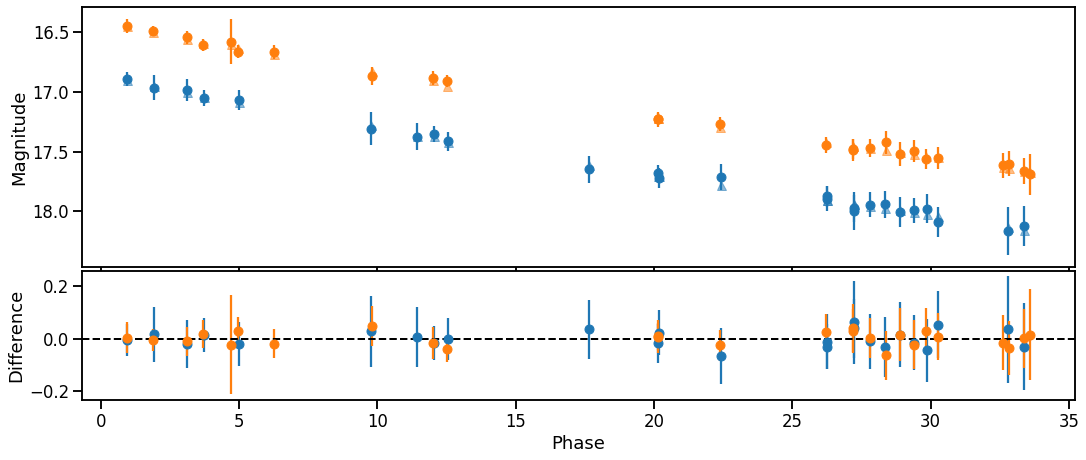

[7.26535977972299, 0.11752811666857416, 0.18318746724659396, 0.7269796944096875, 2.897047992386154, -0.9691002271888559]
0.03147000011178404
[6.932687297097689, 0.23324392262005472, 0.14940385783194193, 0.7269796944096875, 2.897047992386154, -0.9691002271888559]
0.02540732816041693


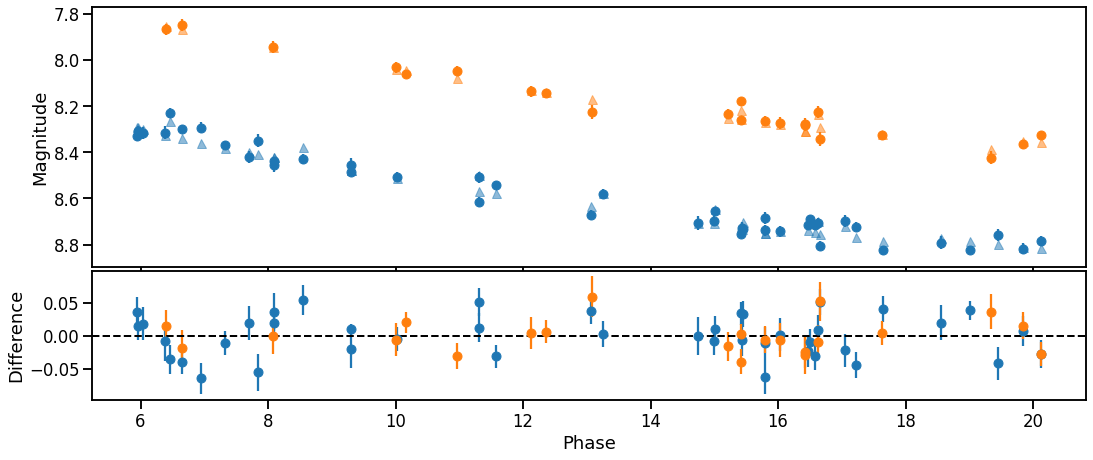

[8.981255838570219, 0.6518624594038595, 0.11543091568049996, 0.6569635420521767, 3.4213319195556445e-13, 1.2015018136307825]
0.03474394983582648
[8.335417159962466, 0.3860911095571425, 0.20024886278069054, 0.6569635420521767, 3.4213319195556445e-13, 1.2015018136307825]
0.029431109649737164


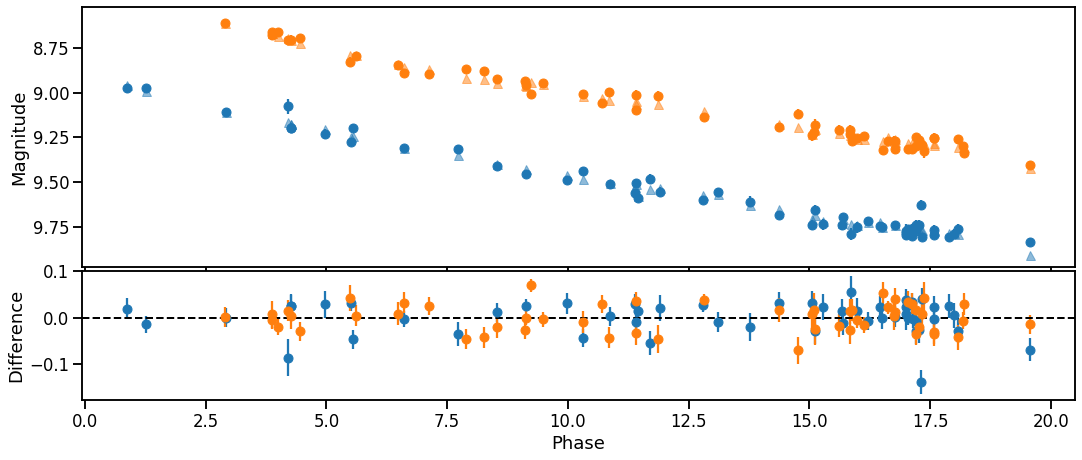

[13.214183042664425, 0.20191436482806033, 0.3652821432560006, 0.7920460479461725, 1.7042163233101622, -1.2233918247769349]
0.034859925579755126
[12.678089870706607, 0.25188831374230697, 0.41958884711956934, 0.7920460479461725, 1.7042163233101622, -1.2233918247769349]
0.034233024216954976


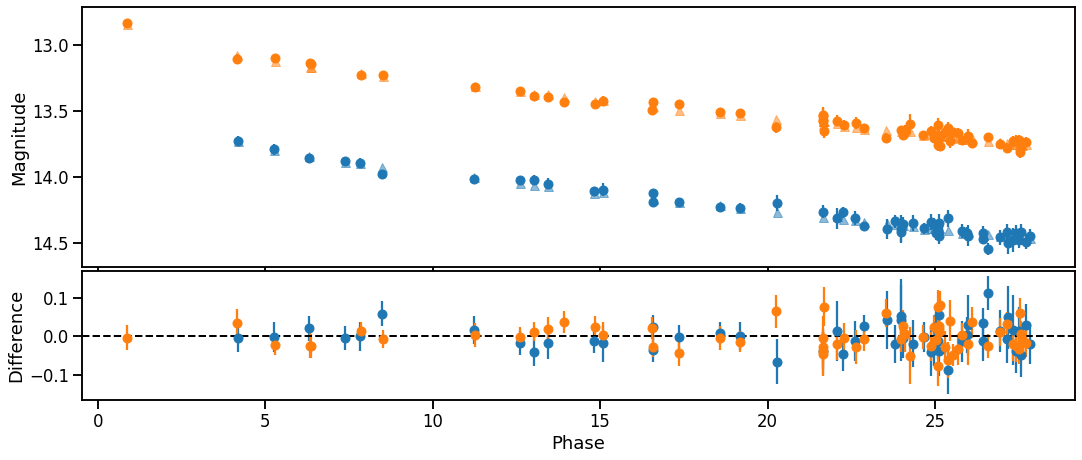

[9.080496247511373, 0.5469548877687209, 0.12543179758883588, 0.9223491649114737, 3.347622313313978, -0.08836343925088912]
0.030366365046411083
[8.82459285860335, 0.7000441104783883, 0.11994715098102508, 0.9223491649114737, 3.347622313313978, -0.08836343925088912]
0.037755299782864876


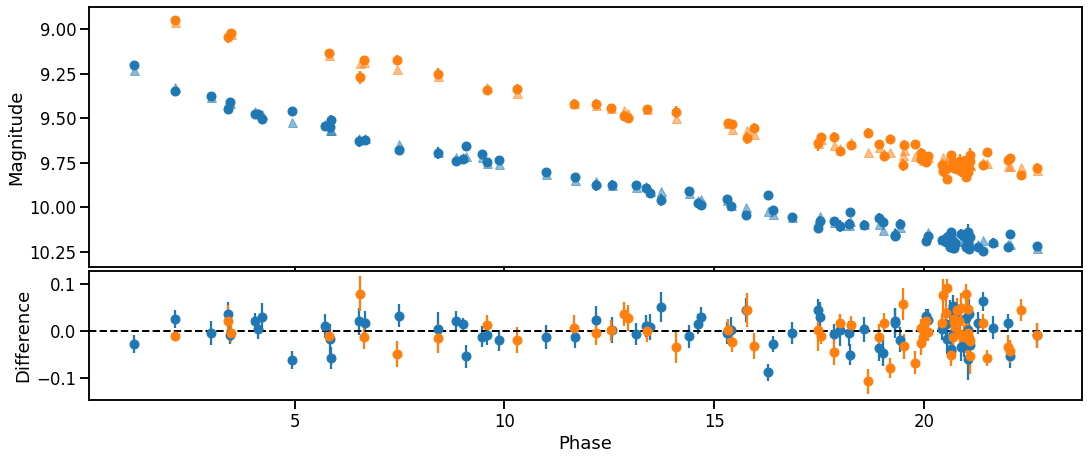

In [14]:
N=5
for ssnamenr in good['ssnamenr'].values[0:N]:
    plot_ast(ssnamenr)

## G1>0.5, G2>0.5

In [27]:
# mask = ~pd.isnull(pdf['rms'])
mask = (data['G1_1'] > 0.5) & (data['G2_1'] > 0.5)
bad = data[~mask_sHG1G2 & mask].sort_values('chi2red', ascending=False)

In [28]:
# they all had a good fit
bad.groupby('fit').size()

fit
0.0    2858
dtype: int64

In [29]:
bad.groupby('status').size()

status
0.0      44
2.0    2514
3.0     150
4.0     150
dtype: int64

In [40]:
bad.head(5)[['ssnamenr', 'fit', 'status', 'rms_1', 'rms_2', 'rms', 'chi2red', 'G1_1', 'G2_1', 'H_1', 'err_H_1']]

,ssnamenr,fit,status,rms_1,rms_2,rms,chi2red,G1_1,G2_1,H_1,err_H_1
37080,192686,0.0,2.0,0.157784,0.826748,0.618944,336.565125,1.000000,0.617773,16.700510,16.825310
44984,134809,0.0,2.0,0.230287,0.595835,0.462349,327.861206,1.000000,1.000000,16.048649,1.706078
29627,30192,0.0,0.0,0.748110,0.951918,0.866685,298.816071,0.951675,0.992494,17.042532,4.448891
90655,114523,0.0,0.0,0.913229,0.655446,0.752867,260.927704,0.649878,0.982074,18.122530,10.561179
114885,26793,0.0,2.0,0.322671,0.482088,0.412561,216.730209,1.000000,0.693005,14.803702,9.884865


### No convergence

[15.925306011864071, 0.35676995524719574, 0.3693899098418591, 0.100000000029592, 2.6857027819394994, -1.2458466686151088]
[15.096202323564446, 0.20192163015182066, 0.3198171849716081, 0.100000000029592, 2.6857027819394994, -1.2458466686151088]


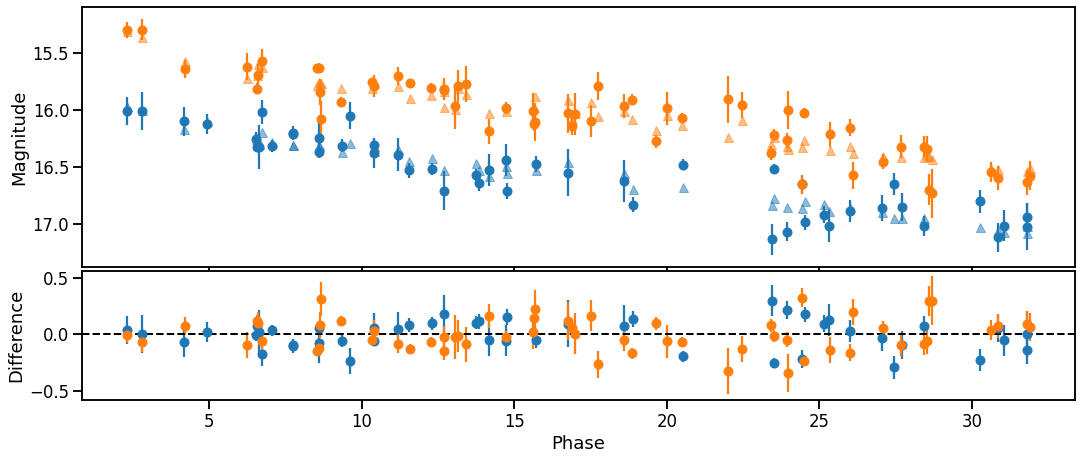

[16.319282322824662, 2.1902040573119844e-05, 0.3307625697968333, 0.5532405271898615, 0.9060795695637207, 0.6900616801467462]
[15.70420974111749, 0.00013927789141716007, 0.350482864745216, 0.5532405271898615, 0.9060795695637207, 0.6900616801467462]


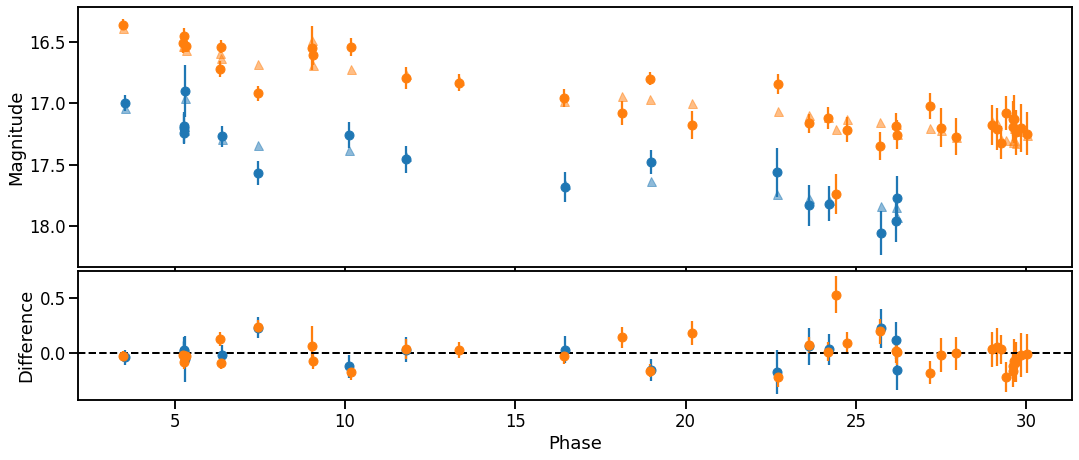

[15.412732076917225, 2.1778257305195576e-34, 0.3199225817572289, 0.3150781651515567, 4.3229757301106275, 0.9409538566302913]
[15.832317237172914, 0.9999999999999909, 0.157790193738269, 0.3150781651515567, 4.3229757301106275, 0.9409538566302913]


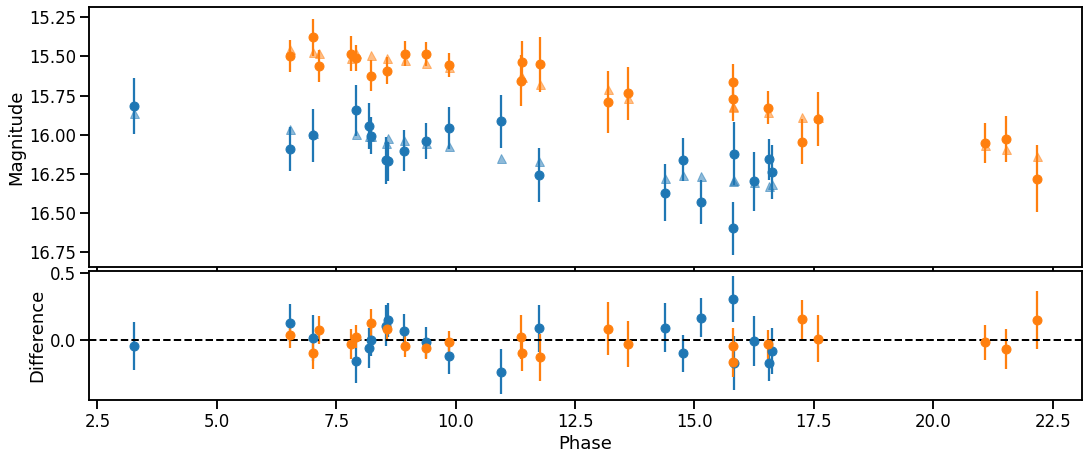

[16.905125217329704, 0.15723799059657903, 0.4743371056139688, 0.6254327391557337, 3.3308321860209356, -0.8963711213756416]
[16.163575866288397, 0.4230717632693348, 0.24756405779748103, 0.6254327391557337, 3.3308321860209356, -0.8963711213756416]


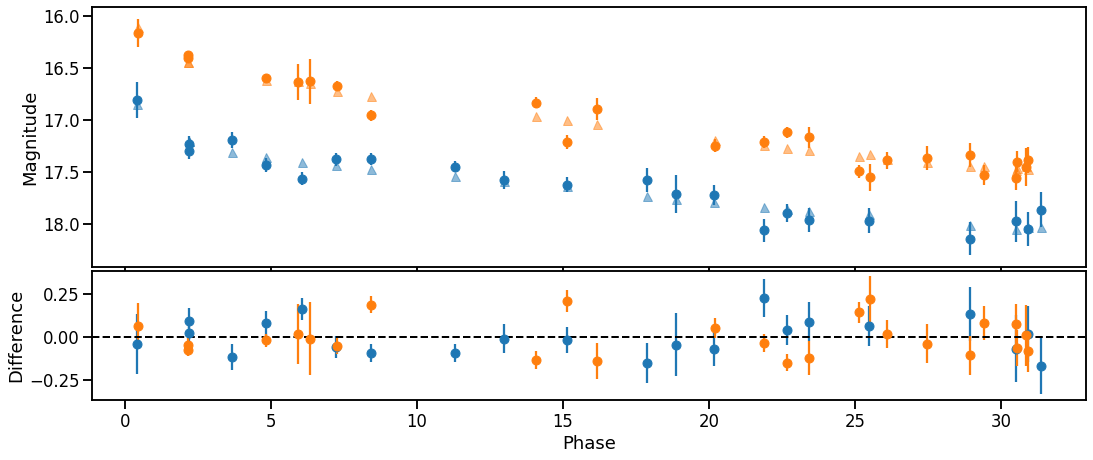

[18.989597996476668, 0.48588417414128, 0.31955061331901374, 0.10000000024632344, 3.2274584114314053, 0.039455934343638144]
[18.3268965613922, 0.5375911405073805, 0.2873709539894519, 0.10000000024632344, 3.2274584114314053, 0.039455934343638144]


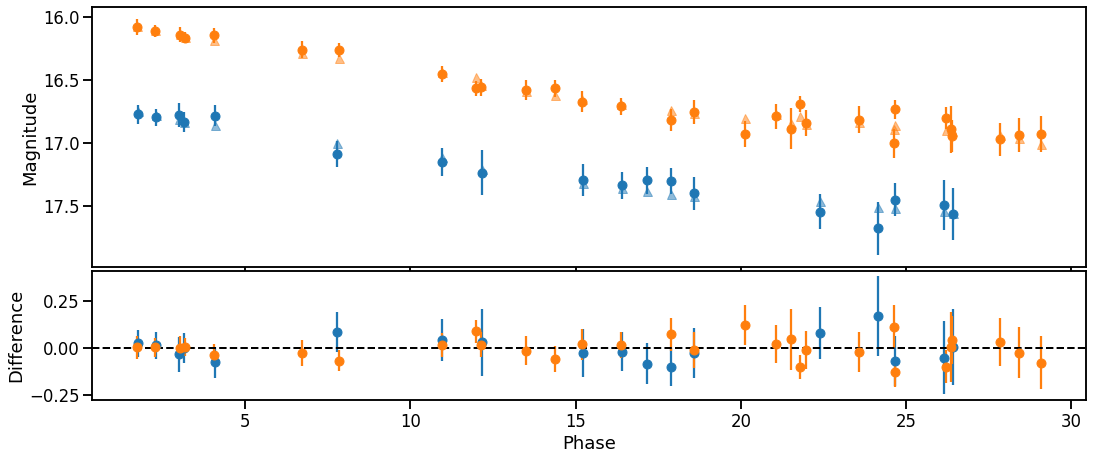

In [41]:
N=5

submask = bad['status'] == 0.0
for ssnamenr in bad['ssnamenr'][submask].values[0:N]:
    plot_ast(ssnamenr)